# Sochastic Gradient Descent with Model Building

### First, we install the SMB package.

In [1]:
!pip install git+https://github.com/sibirbil/SMB.git

  Cloning https://github.com/sibirbil/SMB.git to /private/var/folders/zy/87gspt1523z5dlb99f2955_m0000gn/T/pip-req-build-or3tkcng
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


### Now, we install the SLS package.

In [2]:
!pip install git+https://github.com/IssamLaradji/sls.git

  Cloning https://github.com/IssamLaradji/sls.git to /private/var/folders/zy/87gspt1523z5dlb99f2955_m0000gn/T/pip-req-build-6dk_vc3a


In [3]:
import torch
import torch.optim as optim

import time
import datetime
import numpy as np
import json
import matplotlib.pyplot as plt 

import sls
import smb
from smb import utils as ut

## Train options

In [4]:
# Epochs to train for
epochs = 20

# Dataset-Model
TrainOptions = {1:('mnist', 'mlp'), 
                2:('cifar10', 'resnet34_10'), 
                3:('cifar10', 'densenet10'), 
                4:('cifar100', 'resnet34_100'), 
                5:('cifar100', 'densenet10')
                }
dataset_name, model_name = TrainOptions[1]


# Batch Size
batch_size = 128


## Load dataset and the model

In [5]:
# Check if GPU is available
use_GPU = torch.cuda.is_available()


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
    

# Get Dataset
train_set, test_set, train_loader = ut.get_dataset(dataset_name, batch_size)
n_batches_per_epoch = len(train_loader)

    
opt_out_list = []

## Train with SMB optimizer

SMB optimizer requires a closure function. You can its form below.

In [6]:
independent_batch = False
autoschedule = False

opt_out = {}

if independent_batch:
    opt_out.update({'name':'SMBi'})
else:
    opt_out.update({'name':'SMB'})

opt_out.update({'independent_batch':independent_batch, 
           'autoschedule':autoschedule, 
           'gamma':0.05, 
           'beta':0.9, 
           'lr':0.5, 
           'c':0.1, 
           'eta':0.99, 
           'data':dataset_name, 
           'model':model_name, 
           })

# Get Model
model = ut.get_model(model_name)
if use_GPU:
    model.cuda()
 
 
# loss function
criterion = ut.softmax_loss
 
optimizer = smb.SMB(model.parameters(), 
                lr=opt_out['lr'], 
                c=opt_out['c'], 
                eta=opt_out['eta'], 
                independent_batch=opt_out['independent_batch'], 
                autoschedule=opt_out['autoschedule'],
                n_batches_per_epoch=n_batches_per_epoch)

print('\n' + 'Starting to train with {} optimizer: For {} epochs'.format(opt_out['name'], epochs))

train_loss_list = []
test_acc_list = []
run_time_list = []


for epoch in range(1, epochs+1):
    
    step_type = []
        
    begin = time.time()
    
    # training steps
    model.train()
    
    for batch_index, (data, target) in enumerate(train_loader):
        
        # moves tensors to GPU if available
        if use_GPU:
            data, target = data.cuda(), target.cuda() 
            
        # create loss closure for smb algorithm
        def closure():
            optimizer.zero_grad()
            loss = criterion(model, data, target)
            return loss
        
        # forward pass
        loss = optimizer.step(closure=closure)
        
    end = time.time()
        
    train_loss = ut.compute_loss(model, train_set)
    test_acc = ut.compute_accuracy(model, test_set)
        
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    run_time_list.append(end-begin)
        
    # Display loss statistics
    print(f'Epoch: {epoch}   -   Training Loss: {round(train_loss, 6)}  -  Test Accuracy: {round(test_acc, 6)}  -  Time: {round(end-begin, 2)}')

    
opt_out.update({'train_loss':train_loss_list,
                 'test_acc':test_acc_list,
                 'run_time':run_time_list,
                })

opt_out_list.append(opt_out)


Starting to train with SMB optimizer: For 20 epochs
Epoch: 1   -   Training Loss: 0.160835  -  Test Accuracy: 0.9528  -  Time: 14.73
Epoch: 2   -   Training Loss: 0.10123  -  Test Accuracy: 0.9665  -  Time: 13.26
Epoch: 3   -   Training Loss: 0.084133  -  Test Accuracy: 0.9654  -  Time: 13.05
Epoch: 4   -   Training Loss: 0.084372  -  Test Accuracy: 0.9623  -  Time: 12.94
Epoch: 5   -   Training Loss: 0.048766  -  Test Accuracy: 0.9748  -  Time: 13.03
Epoch: 6   -   Training Loss: 0.038853  -  Test Accuracy: 0.9777  -  Time: 12.89
Epoch: 7   -   Training Loss: 0.043774  -  Test Accuracy: 0.9737  -  Time: 12.64
Epoch: 8   -   Training Loss: 0.040955  -  Test Accuracy: 0.9742  -  Time: 12.79
Epoch: 9   -   Training Loss: 0.030071  -  Test Accuracy: 0.9774  -  Time: 12.82
Epoch: 10   -   Training Loss: 0.014237  -  Test Accuracy: 0.9825  -  Time: 12.85
Epoch: 11   -   Training Loss: 0.009853  -  Test Accuracy: 0.9835  -  Time: 12.93
Epoch: 12   -   Training Loss: 0.00837  -  Test Accurac

## Train with SLS optimizer

In [7]:
opt_out = {'name':'SLS', 
           'lr':1, 
           'c':0.1, 
           'reset_option':1, 
           'data':dataset_name, 
           'model':model_name, 
           }

# Get Model
model = ut.get_model(model_name)
if use_GPU:
    model.cuda()
 
# loss function
criterion = ut.softmax_loss


optimizer = sls.Sls(model.parameters(), 
                    init_step_size=opt_out['lr'], 
                    reset_option=opt_out['reset_option'], 
                    c=opt_out['c'], 
                    n_batches_per_epoch=n_batches_per_epoch
                   )

print('\n' + 'Starting to train with {} optimizer: For {} epochs'.format(opt_out['name'], epochs))


train_loss_list = []
train_iter_loss_list = []
test_acc_list = []
run_time_list = []

loss = None

for epoch in range(1, epochs+1):
        
    begin = time.time()
    
    # training steps
    model.train()
    
    for batch_index, (data, target) in enumerate(train_loader):
        
        # moves tensors to GPU
        if use_GPU:
            data, target = data.cuda(), target.cuda() 
            
        # create loss closure for sls algorithm
        closure = lambda :  criterion(model, data, target)  
        # clears gradients
        optimizer.zero_grad()
        
        loss = optimizer.step(closure=closure)
        
        train_iter_loss_list.append(loss.item())
        
    end = time.time()
    
    train_loss = ut.compute_loss(model, train_set)
    test_acc = ut.compute_accuracy(model, test_set)
        
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    run_time_list.append(end-begin)
        
    # Display loss statistics
    print(f'Epoch: {epoch}   -   Training Loss: {round(train_loss, 6)}  -  Test Accuracy: {round(test_acc, 6)}  -  Time: {round(end-begin, 2)}')
    
    #print(epoch, end=' ')
    
opt_out.update({'train_loss':train_loss_list,
                 'test_acc':test_acc_list,
                 'run_time':run_time_list,
                 'train_iter_loss':train_iter_loss_list,
                })

opt_out_list.append(opt_out)


Starting to train with SLS optimizer: For 20 epochs
Epoch: 1   -   Training Loss: 0.31004  -  Test Accuracy: 0.9141  -  Time: 13.06
Epoch: 2   -   Training Loss: 0.292539  -  Test Accuracy: 0.9096  -  Time: 13.04
Epoch: 3   -   Training Loss: 0.173915  -  Test Accuracy: 0.9491  -  Time: 12.83
Epoch: 4   -   Training Loss: 0.13711  -  Test Accuracy: 0.9553  -  Time: 12.73
Epoch: 5   -   Training Loss: 0.111351  -  Test Accuracy: 0.9636  -  Time: 12.99
Epoch: 6   -   Training Loss: 0.143678  -  Test Accuracy: 0.9531  -  Time: 12.85
Epoch: 7   -   Training Loss: 0.07906  -  Test Accuracy: 0.9687  -  Time: 12.93
Epoch: 8   -   Training Loss: 0.072713  -  Test Accuracy: 0.9695  -  Time: 12.97
Epoch: 9   -   Training Loss: 0.057503  -  Test Accuracy: 0.974  -  Time: 12.89
Epoch: 10   -   Training Loss: 0.050342  -  Test Accuracy: 0.976  -  Time: 12.94
Epoch: 11   -   Training Loss: 0.053327  -  Test Accuracy: 0.9703  -  Time: 13.02
Epoch: 12   -   Training Loss: 0.036139  -  Test Accuracy: 

## Train with ADAM optimizer

In [8]:
opt_out = {'name':'Adam', 
           'lr':0.001, 
           'data':dataset_name, 
           'model':model_name,
           } 

# Get Model
model = ut.get_model(model_name)
if use_GPU:
    model.cuda()
 
# loss function
criterion = ut.softmax_loss

# optimizer
optimizer = optim.Adam(model.parameters(), lr = opt_out['lr'])


print('\n' + 'Starting to train with {} optimizer: For {} epochs'.format(opt_out['name'], epochs))


train_loss_list = []
test_acc_list = []
run_time_list = []
    

for epoch in range(1, epochs+1):
        
    begin = time.time()

    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):            
            
        # moves tensors to GPU
        if use_GPU:
            data, target = data.cuda(), target.cuda()     
        # clears gradients
        optimizer.zero_grad()
        # loss in batch
        loss = criterion(model, data, target)
        # backward pass for loss gradient
        loss.backward()
            
            
        # update paremeters
        optimizer.step()
            
    end = time.time()
    
    
    # Calculate metrics
    train_loss = ut.compute_loss(model, train_set)
    test_acc = ut.compute_accuracy(model, test_set)
    
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    run_time_list.append(end-begin)
        
    # Display loss statistics
    print(f'Epoch: {epoch}   -   Training Loss: {round(train_loss, 6)}   -   Test Accuracy: {round(test_acc, 6)}  -  Time: {round(end-begin, 2)}')


opt_out.update({'train_loss':train_loss_list,
                 'test_acc':test_acc_list,
                 'run_time':run_time_list,
                })

opt_out_list.append(opt_out)


Starting to train with Adam optimizer: For 20 epochs
Epoch: 1   -   Training Loss: 0.191512   -   Test Accuracy: 0.938  -  Time: 11.85
Epoch: 2   -   Training Loss: 0.128072   -   Test Accuracy: 0.9552  -  Time: 12.07
Epoch: 3   -   Training Loss: 0.073522   -   Test Accuracy: 0.9713  -  Time: 12.3
Epoch: 4   -   Training Loss: 0.064399   -   Test Accuracy: 0.9712  -  Time: 12.09
Epoch: 5   -   Training Loss: 0.072171   -   Test Accuracy: 0.9683  -  Time: 12.09
Epoch: 6   -   Training Loss: 0.048156   -   Test Accuracy: 0.9746  -  Time: 12.13
Epoch: 7   -   Training Loss: 0.051761   -   Test Accuracy: 0.9712  -  Time: 12.06
Epoch: 8   -   Training Loss: 0.04866   -   Test Accuracy: 0.9707  -  Time: 12.01
Epoch: 9   -   Training Loss: 0.029394   -   Test Accuracy: 0.9774  -  Time: 11.98
Epoch: 10   -   Training Loss: 0.026369   -   Test Accuracy: 0.9786  -  Time: 11.99
Epoch: 11   -   Training Loss: 0.029084   -   Test Accuracy: 0.9759  -  Time: 12.03
Epoch: 12   -   Training Loss: 0.0

## Train with SGD optimizer

In [9]:
opt_out = {'name':'SGD', 
           'lr':0.1, 
           'data':dataset_name, 
           'model':model_name,
           }

# Get Model
model = ut.get_model(model_name)
if use_GPU:
    model.cuda()
 
# loss function
criterion = ut.softmax_loss

# optimizer
optimizer = optim.SGD(model.parameters(), lr = opt_out['lr'])

print('\n' + 'Starting to train with {} optimizer: For {} epochs'.format(opt_out['name'], epochs))


train_loss_list = []
test_acc_list = []
run_time_list = []
    

for epoch in range(1, epochs+1):
        
    begin = time.time()

    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):            
            
        # moves tensors to GPU
        if use_GPU:
            data, target = data.cuda(), target.cuda()     
        # clears gradients
        optimizer.zero_grad()
        # loss in batch
        loss = criterion(model, data, target)
        # backward pass for loss gradient
        loss.backward()
            
            
        # update paremeters
        optimizer.step()
            
    end = time.time()
    
    
    # Calculate metrics
    train_loss = ut.compute_loss(model, train_set)
    test_acc = ut.compute_accuracy(model, test_set)
    
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    run_time_list.append(end-begin)
        
    # Display loss statistics
    print(f'Epoch: {epoch}   -   Training Loss: {round(train_loss, 6)}   -   Test Accuracy: {round(test_acc, 6)}  -  Time: {round(end-begin, 2)}')


opt_out.update({'train_loss':train_loss_list,
                 'test_acc':test_acc_list,
                 'run_time':run_time_list,
                })

opt_out_list.append(opt_out)


Starting to train with SGD optimizer: For 20 epochs
Epoch: 1   -   Training Loss: 0.246461   -   Test Accuracy: 0.9292  -  Time: 10.32
Epoch: 2   -   Training Loss: 0.157231   -   Test Accuracy: 0.9521  -  Time: 10.38
Epoch: 3   -   Training Loss: 0.107595   -   Test Accuracy: 0.9622  -  Time: 10.36
Epoch: 4   -   Training Loss: 0.087586   -   Test Accuracy: 0.9682  -  Time: 10.31
Epoch: 5   -   Training Loss: 0.077705   -   Test Accuracy: 0.9713  -  Time: 10.36
Epoch: 6   -   Training Loss: 0.06385   -   Test Accuracy: 0.9729  -  Time: 10.46
Epoch: 7   -   Training Loss: 0.056431   -   Test Accuracy: 0.974  -  Time: 10.34
Epoch: 8   -   Training Loss: 0.088069   -   Test Accuracy: 0.9615  -  Time: 10.81
Epoch: 9   -   Training Loss: 0.042344   -   Test Accuracy: 0.9759  -  Time: 10.79
Epoch: 10   -   Training Loss: 0.035499   -   Test Accuracy: 0.976  -  Time: 10.77
Epoch: 11   -   Training Loss: 0.029453   -   Test Accuracy: 0.979  -  Time: 10.7
Epoch: 12   -   Training Loss: 0.0404

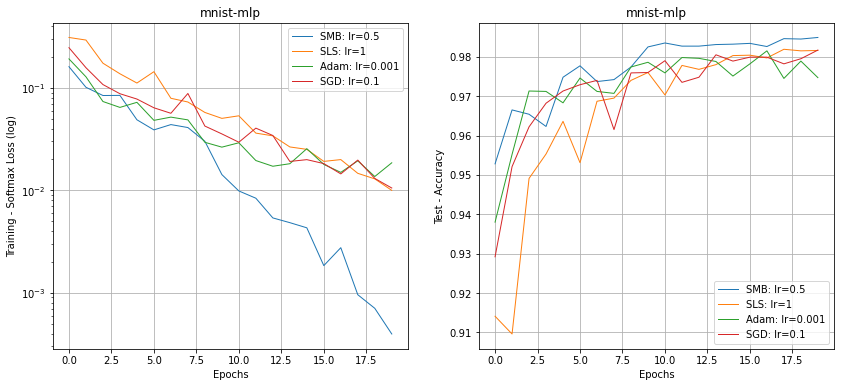

In [10]:
ut.show_loss_acc_graph(opt_out_list, "{}-{}".format(dataset_name, model_name))

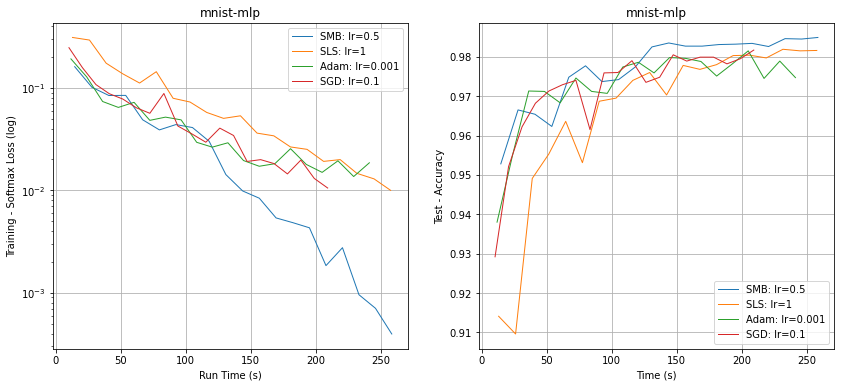

In [11]:
ut.show_time_graph(opt_out_list, "{}-{}".format(dataset_name, model_name))